# Generalized Independent Noise (GIN)

Generalized Independent Noise (GIN) is a method for causal discovery for tabular data when there are hidden confounder variables.

Let X denote the set of all the observed variables and L the set of unknown groud truth hidden variables. 
Then this algorithm makes the following **assumptions**:
1. There is no observed variable in X, that is an ancestor of any latent variables in L.
2. The noise terms are non-Gaussian.
3. Each latent variable set L' in L, in which every latent variable directly causes the same set of 
observed variables, has at least 2Dim(L') pure measurement variables as children.
4. There is no direct edge between observed variables.


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import pickle as pkl
import time
import random

In [2]:

from causalai.models.tabular.gin import GIN
from causalai.models.common.CI_tests.partial_correlation import PartialCorrelation
from causalai.models.common.CI_tests.discrete_ci_tests import DiscreteCI_tests
from causalai.models.common.CI_tests.kci import KCI


# also importing data object, data transform object, and prior knowledge object, and the graph plotting function
from causalai.data.data_generator import DataGenerator, GenerateRandomTabularSEM
from causalai.data.tabular import TabularData
from causalai.data.transforms.time_series import StandardizeTransform
from causalai.models.common.prior_knowledge import PriorKnowledge
from causalai.misc.misc import plot_graph, get_precision_recall, get_precision_recall_skeleton, make_symmetric

## Load and Visualize Data

Load the dataset and visualize the ground truth causal graph. For the purpose of this example, we will use a synthetic dataset available in our repository.

Note that the assumption of GIN restricts the way edges are allowed between the nodes. As described above, latent variables cause each other, as well as the observed variables, and there are no edges between the observed variables. Finally, the noise terms must be non-Gaussian. We generate such a graph and data below.

### Example 1

In [3]:

def noise_fn(num_samples):
    return np.random.uniform(-1., 1., size=num_samples)
def noise_fn1(num_samples):
    return np.random.uniform(-0.2, 0.2, size=num_samples)
fn = lambda x:x
coef = 1.
sem = {
        'L0': [], 
        'L1': [('L0', coef, fn)], 
        'a': [('L0', coef, fn),], 
        'b': [('L0', coef, fn),], 
        'c': [('L1', coef, fn),], 
        'd': [('L1', coef, fn),], 
        }
T = 500
nvars = len(sem.keys())
noise_fn = [noise_fn]*2 +[noise_fn1]*(nvars-2)
data_array0, var_names, graph_gt = DataGenerator(sem, T=T, seed=0, discrete=False, noise_fn=noise_fn)

print(f'data_array shape {data_array0.shape}')
graph_gt

data_array shape (500, 6)


{'L0': [], 'L1': ['L0'], 'a': ['L0'], 'b': ['L0'], 'c': ['L1'], 'd': ['L1']}



Now we perform the following operations:

1. Standardize the data arrays
2. Create the data object

**NOTE**: We first remove the variables L0 and L1 from the data to treat them as hidden variables. 

In [4]:

data_array = data_array0[:,2:] # remove L0 and L1 and treat them as latent variables

# 1.
StandardizeTransform_ = StandardizeTransform()
StandardizeTransform_.fit(data_array)

data_trans = StandardizeTransform_.transform(data_array)

# 2.
data_obj = TabularData(data_trans, var_names=var_names[2:])


We visualize the data and graph below:

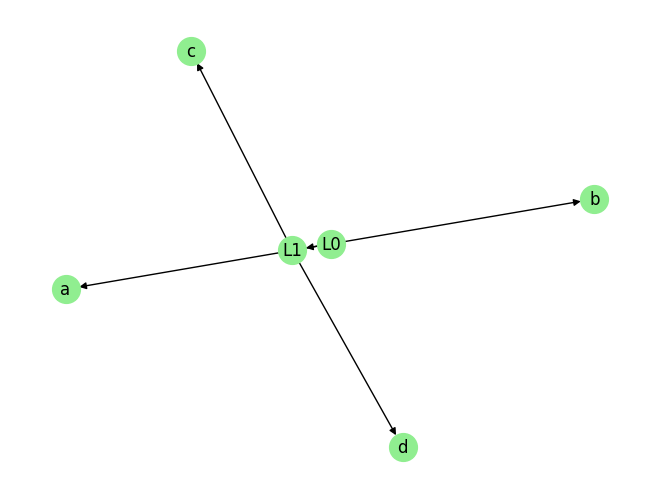

In [5]:
plot_graph(graph_gt, node_size=400)

In [6]:

pvalue_thres = 0.01
CI_test = KCI(chunk_size=1000) 
# chunk_size refers to the max kernel size used by the KCI module and is meant to control the computational budget
# chunk_size does not affect results in this case since the number of samples is 500<1000 in this example
model = GIN(
        data=data_obj,
        prior_knowledge=None, #  prior_knowledge is not supported in GIN
        CI_test=CI_test,
        use_multiprocessing=True # use_multiprocessing not supported
        )


In [7]:
result = model.run(pvalue_thres=pvalue_thres)
model.causal_order

[['a', 'b'], ['c', 'd']]

In [8]:
print(f'Predicted parents:')

graph_est={n:[] for n in result.keys()}
for key in result.keys():
    parents = result[key]['parents']
    graph_est[key].extend(parents)
    print(f'{key}: {parents}')
print()

print(f"\nGround truth parents:")  
for key in graph_gt.keys():
    print(f'{key}: {graph_gt[key]}')
    
precision, recall, f1_score = get_precision_recall(graph_est, graph_gt)
print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')


Predicted parents:
L0: []
a: ['L0']
b: ['L0']
L1: ['L0']
c: ['L1']
d: ['L1']


Ground truth parents:
L0: []
L1: ['L0']
a: ['L0']
b: ['L0']
c: ['L1']
d: ['L1']
Precision 1.00, Recall: 1.00, F1 score: 1.00


**Note**: To avoid confusion, we note that we have used L0 and L1 as the names of the latent variables in the ground truth data variable names. The GIN algorithm implementation in the CausalAI library use the naming convention 'Li' to name the latent variables, where i an integer. This is what makes the name of the estimated latent variable names look identical to the ground truth latet variable names. There is no magic happening here.

### Example 2

In [9]:

def noise_fn(num_samples):
    return np.random.uniform(-1., 1., size=num_samples)
def noise_fn1(num_samples):
    return np.random.uniform(-0.2, 0.2, size=num_samples)
fn = lambda x:x
coef = 1.4
sem = {
        'L0': [], 
        'L1': [('L0', coef, fn)], 
        'L2': [('L0', coef, fn), ('L1', coef, fn)], 
        'a': [('L0', coef, fn),], 
        'b': [('L0', coef, fn),], 
        'c': [('L0', coef, fn),], 
        'd': [('L1', coef, fn),], 
        'e': [('L1', coef, fn),], 
        'f': [('L1', coef, fn),], 
        'g': [('L2', coef, fn),], 
        'h': [('L2', coef, fn),], 
        'i': [('L2', coef, fn),], 
        }
T = 500
nvars = len(sem.keys())
noise_fn = [noise_fn]*3 +[noise_fn1]*(nvars-3)
data_array0, var_names, graph_gt = DataGenerator(sem, T=T, seed=1, discrete=False, noise_fn=noise_fn)

print(f'data_array shape {data_array0.shape}')
# print(var_names)
graph_gt


data_array shape (500, 12)


{'L0': [],
 'L1': ['L0'],
 'L2': ['L0', 'L1'],
 'a': ['L0'],
 'b': ['L0'],
 'c': ['L0'],
 'd': ['L1'],
 'e': ['L1'],
 'f': ['L1'],
 'g': ['L2'],
 'h': ['L2'],
 'i': ['L2']}

In [10]:

data_array = data_array0[:,3:] # remove L0, L1 and L2 and treat them as latent variables

# # 1.
StandardizeTransform_ = StandardizeTransform()
StandardizeTransform_.fit(data_array)

data_trans = StandardizeTransform_.transform(data_array)

# 2.
data_obj = TabularData(data_trans, var_names=var_names[3:])


In [11]:

pvalue_thres = 0.01
CI_test = KCI(chunk_size=1000)
model = GIN(
        data=data_obj,
        prior_knowledge=None, #  prior_knowledge is not supported in GIN
        CI_test=CI_test,
        use_multiprocessing=True
        )


In [12]:
result = model.run(pvalue_thres=pvalue_thres)
model.causal_order

[['a', 'b', 'c'], ['d', 'e', 'f'], ['g', 'i', 'h']]

In [13]:
print(f'Predicted parents:')

graph_est={n:[] for n in result.keys()}
for key in result.keys():
    parents = result[key]['parents']
    graph_est[key].extend(parents)
    print(f'{key}: {parents}')
print()

print(f"\nGround truth parents:")  
for key in graph_gt.keys():
    print(f'{key}: {graph_gt[key]}')
    
precision, recall, f1_score = get_precision_recall(graph_est, graph_gt)
print(f'Precision {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1_score:.2f}')


Predicted parents:
L0: []
a: ['L0']
b: ['L0']
c: ['L0']
L1: ['L0']
d: ['L1']
e: ['L1']
f: ['L1']
L2: ['L0', 'L1']
g: ['L2']
i: ['L2']
h: ['L2']


Ground truth parents:
L0: []
L1: ['L0']
L2: ['L0', 'L1']
a: ['L0']
b: ['L0']
c: ['L0']
d: ['L1']
e: ['L1']
f: ['L1']
g: ['L2']
h: ['L2']
i: ['L2']
Precision 1.00, Recall: 1.00, F1 score: 1.00


**Note**: To avoid confusion, we note that we have used L0, L1 and L2 as the names of the latent variables in the ground truth data variable names. The GIN algorithm implementation in the CausalAI library use the naming convention 'Li' to name the latent variables, where i an integer. This is what makes the name of the estimated latent variable names look identical to the ground truth latet variable names. There is no magic happening here.